## Créditos

O conteúdo deste notebook usa material das seguintes fontes:

- [Starter: Anime Face Dataset](https://www.kaggle.com/splcher/starter-anime-face-dataset)

- [Deep Learning Wizard](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_logistic_regression/)

- [Deep Learning with PyTorch: Zero to GANs](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans)

- [Machine Learning Glossary](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

# Introdução à modelagem generativa

As redes neurais profundas são usadas principalmente para aprendizado supervisionado: classificação ou regressão. Generative Adversarial Networks ou GANs, no entanto, são redes neurais usadas para um propósito diferente: *modelagem generativa*.

> A modelagem generativa é uma tarefa de aprendizado não supervisionado em aprendizado de máquina que envolve descobrir e aprender automaticamente as regularidades ou padrões nos dados de entrada de forma que o modelo (após o treinamento) possa ser usado para gerar ou produzir novos exemplos que plausivelmente poderiam ter sido extraídos do conjunto de dados original. - [Fonte](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

Para ter uma ideia do poder dos modelos generativos, basta visitar [thispersondoesnotexist.com](https://thispersondoesnotexist.com). Toda vez que você recarrega a página, uma nova imagem do rosto de uma pessoa é gerada. Alguns dos resultados são impressionantes:

<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

Embora existam muitas abordagens usadas para modelagem generativa, a Generative Adversarial Network adota a seguinte abordagem:

<center><img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px; background-color:#082767"/></center>

Em uma GAN, há duas (sub-)redes neurais acopladas. Essas redes são denominadas *Gerador* e *Discriminador*. 

- O gerador gera uma amostra "falsa" a partir de um vetor/matriz aleatório. 
- O discriminador tenta detectar se uma determinada amostra apresentada a ele é "real" (i.e., coletada dos dados de treinamento) ou "falsa" (i.e., gerada pelo gerador). 

O treinamento de uma GAN acontece em conjunto: treinamos o discriminador por algumas épocas. Em seguida, treinamos o gerador por algumas épocas. Esse procedimento de treinamento intercalado é repetido. O objetivo é que, ao longo dos ciclos de aprendizado, tanto o gerador quanto o discriminador fiquem cada vez melhores em suas respectivas tarefas.

GANs são notoriamente difíceis de treinar e são extremamente sensíveis à escolha de hiperparâmetros, funções de ativação e regularização. Neste tutorial, vamos treinar uma GAN para gerar imagens de rostos de personagens de anime.

<center><img src="https://i.imgur.com/NaKtJs0.png" width="360" style="margin-bottom:32px"/></center>


Usaremos o [Anime Face Dataset](https://github.com/Mckinsey666/Anime-Face-Dataset), que consiste em mais de 63.000 faces de anime. Observe que a modelagem generativa é uma tarefa de aprendizado não supervisionada. Portanto, as imagens não possuem rótulos.

## Baixando e explorando os dados

Podemos usar a biblioteca [`opendatasets`](https://github.com/JovianML/opendatasets) para baixar o [conjunto de dados](https://www.kaggle.com/splcher/animefacedataset) do Kaggle. `opendatasets` usa a [API oficial do Kaggle](https://github.com/Kaggle/kaggle-api) para baixar conjuntos de dados do Kaggle. Siga estas etapas para encontrar suas credenciais de API:

1. Faça login em [https://kaggle.com/](https://kaggle.com), clique na sua foto de perfil no canto superior direito e selecione "Minha conta" no menu.

2. Role para baixo até a seção "API" e clique em "Criar novo token de API". Isso fará o download de um arquivo `kaggle.json` com o seguinte conteúdo:

```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. Ao executar `opendatsets.download`, você será solicitado a inserir seu nome de usuário e a API Kaggle, que você pode obter do arquivo baixado na etapa 2.

Observe que você precisa baixar o arquivo `kaggle.json` apenas uma vez. No Google Colab, você também pode fazer upload do arquivo `kaggle.json` usando a guia de arquivos e as credenciais serão lidas automaticamente.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ebezerra
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:03<00:00, 117MB/s]


O conjunto de dados tem uma única pasta chamada `images` que contém todas as mais de 63.000 imagens em formato JPG.

In [ ]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['20212_2007.jpg', '52179_2015.jpg', '40332_2012.jpg', '49609_2015.jpg', '40773_2013.jpg', '15147_2006.jpg', '3118_2002.jpg', '52564_2016.jpg', '56529_2017.jpg', '16050_2006.jpg']


Vamos carregar este conjunto de dados usando a classe `ImageFolder` de `torchvision`. Também redimensionaremos e cortaremos as imagens para 64x64 px e normalizaremos os valores de pixel com média e desvio padrão de $0.5$ para cada canal. Isso garantirá que os valores de pixel estejam no intervalo `(-1, 1)`, o que é mais conveniente para treinar o discriminador. Também criaremos um carregador de dados para carregar os dados em lotes.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Vamos criar funções auxiliares para desnormalizar os tensores de imagem e exibir algumas imagens de amostra de um lote de treinamento.

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


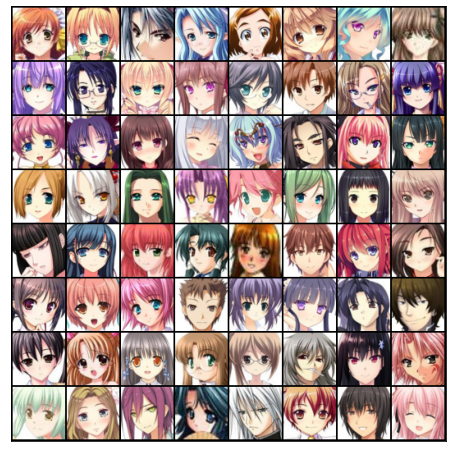

In [ ]:
show_batch(train_dl)

## Usando uma GPU

Para usar uma GPU, se houver uma disponível, definimos algumas funções auxiliares (`get_default_device` & `to_device`) e uma classe auxiliar `DeviceDataLoader` para mover nosso modelo e dados para a GPU, se houver uma disponível.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Com base em onde você está executando este notebook, seu dispositivo padrão pode ser uma CPU (`torch.device('cpu')`) ou uma GPU (`torch.device('cuda')`).

In [ ]:
device = get_default_device()
device

device(type='cuda')

Agora podemos mover nosso carregador de dados de treinamento usando `DeviceDataLoader` para transferir automaticamente lotes de dados para a GPU (se disponível).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminador

O discriminador recebe uma imagem como entrada e tenta classificá-la como "real" ou "gerada". Nesse sentido, o discriminador é um modelo de rede neural que realiza **classificação binária**. 

Vamos definir o discriminador como uma rede neural convolucional (CNN) que gera um único número para cada imagem de entrada. Usaremos o passo (*stride*)  de 2 para reduzir progressivamente o tamanho dos mapas de características.

<center><img src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif" width="360" style="margin-bottom:32px"/></center>


In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Observe que estamos usando a função de ativação denominada *Leaky ReLU* para o discriminador.

<center><img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420"></center>


>  Diferente da função ReLU normal, Leaky ReLU permite a passagem de um pequeno sinal de gradiente para valores negativos. Como resultado, faz com que os gradientes do discriminador fluam mais fortes para o gerador. Em vez de passar um gradiente (slope) de 0 na passagem de back-prop, ele passa um pequeno gradiente negativo.  - [Source](https://sthalles.github.io/advanced_gans/)

Assim como qualquer outro modelo de classificação binária, a saída do discriminador é um único número entre 0 e 1, que pode ser interpretado como a probabilidade da imagem de entrada ser real, ou seja, selecionada do conjunto de dados original.

Vamos mover o modelo do discriminador para o dispositivo escolhido.

In [ ]:
discriminator = to_device(discriminator, device)

## Gerador

A entrada para o gerador é tipicamente um vetor ou uma matriz de números aleatórios (chamado de *tensor latente*) que é usado como semente para gerar uma imagem. O gerador converterá um tensor latente de dimensões `(128, 1, 1)` em um tensor de imagem com dimensões `3 x 64 x 64`. Repare que, não por acaso, essas são as dimensões das imagens esperadas na entrada do discriminador. 

Para gerar uma imagem na saída, o gerador usa uma sequência de camadas *convolução transposta* (também chamada de *deconvolução*)[Saber mais](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

<center><img src="https://i.imgur.com/DRvK546.gif" width="420"></center>

No PyTorch, a classe `ConvTranspose2d` implementa a operação de convolução transposta. 

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Repare o uso da função de ativação *tangente hiperbólica* na camada de saída do gerador.

<center>
<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >
</center>

> "A função de ativação ReLU (Nair & Hinton, 2010) é utilizada no gerador com exceção da camada de saída, que utiliza a função tanh. **Observamos** que o uso de uma ativação limitada permitiu que o modelo aprendesse mais rapidamente a saturar e cobrir o espaço de cores da distribuição de treinamento. Dentro do discriminador constatamos a ativação retificada ReLU com vazamento (Maas et al., 2013) (Xu et al., 2015) funciona bem, especialmente para modelagem de alta resolução." - [Fonte](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)

Observe que, como as saídas da ativação de tanh estão no intervalo `[-1,1]`, aplicamos a transformação semelhante às imagens no conjunto de dados de treinamento. 

Vamos gerar algumas saídas usando o gerador e visualizá-las como imagens transformando e desnormalizando a saída.


torch.Size([128, 3, 64, 64])


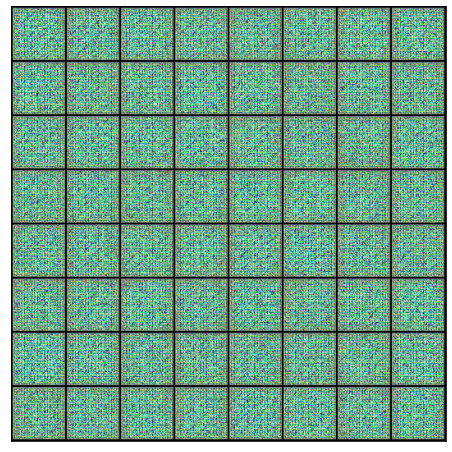

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Como se poderia esperar, a saída do gerador é basicamente um ruído aleatório, já que ainda não o treinamos.

Vamos mover o gerador para o dispositivo escolhido.

In [ ]:
generator = to_device(generator, device)

## Treinamento do Discriminador


O discriminador é um modelo de classificação binária. Esperamos que o discriminador produza $1$ se a imagem fornecida para ele foi selecionada do conjunto de dados real e $0$ se essa imagem foi produzida pelo gerador.

Podemos usar a função de custo de *entropia cruzada binária* (*binary cross-entropy*) para quantificar quão bem ele é capaz de diferenciar entre imagens reais e geradas.

<center>
<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >
</center>

No PyTorch, a função `F.binary_cross_entropy` fornece a implementação da entropia cruzada binária.

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Aqui estão as etapas envolvidas no treinamento do discriminador.

- Primeiro passamos um lote de imagens reais e calculamos a perda, definindo os rótulos de destino para 1.

- Em seguida, passamos um lote de imagens falsas (i.e., produzidas pelo gerador) para o discriminador e calculamos a função de custo, definindo os rótulos de destino como 0.

- Finalmente somamos as duas funções de custo e usamos o valor total para realizar o gradiente descendente para ajustar os pesos do discriminador.

É importante notar que não alteramos os pesos do modelo do gerador enquanto treinamos o discriminador (`opt_d` afeta apenas o `discriminator.parameters()`)


## Treinamento do Gerador

Como as saídas do gerador são imagens, não é óbvio como podemos treinar esse componente. É aqui que empregamos um truque bastante elegante, que é usar o discriminador como parte da função de custo. A seguir, uma descrição de como isso é feito:

1. Geramos um lote de imagens usando o gerador; em seguida passamos essas imagens para o discriminador classificar.

2. Calculamos a função de custo definindo os rótulos de destino como iguais a $1$ (rótulo para "real"). Fazemos isso porque o objetivo do gerador é "enganar" o discriminador.

3. Usamos o valor da função de custo para computar os gradientes e passar para o algoritmo gradiente descendente, ou seja, alterar os pesos do gerador, para que ele fique melhor na geração de imagens verossímeis (i.e., parecidas com reais) para "enganar" o discriminador.

O código a seguir implementa os passos descritos acima.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Vamos criar um diretório onde podemos salvar saídas intermediárias do gerador para inspecionar visualmente o progresso do modelo. Também criaremos uma função auxiliar para exportar as imagens geradas.

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Usaremos um conjunto fixo de vetores de entrada para o gerador para ver como as imagens geradas individuais evoluem ao longo do tempo à medida que treinamos o modelo. Vamos salvar um conjunto de imagens antes de começarmos a treinar nosso modelo.

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


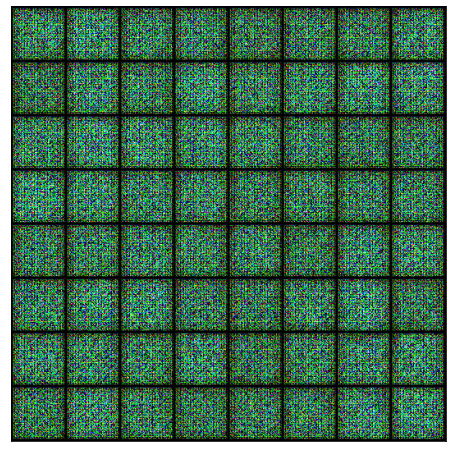

In [ ]:
save_samples(0, fixed_latent)

## Ciclo completo de treinamento

Vamos definir uma função `fit` para treinar o discriminador e o gerador em conjunto para cada lote de dados de treinamento. Usaremos o otimizador Adam com alguns parâmetros personalizados (betas) que funcionam bem para GANs. Também salvaremos algumas imagens geradas por amostra em intervalos regulares para inspeção.

<img src="https://i.imgur.com/mdeaLZy.png" style="max-width:120px; margin-bottom:32px"/>



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

Agora estamos prontos para treinar o modelo. Tente diferentes taxas de aprendizado para ver se você consegue manter o equilíbrio entre o treinamento do gerador e do discriminador.

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/25], loss_g: 6.1487, loss_d: 1.1105, real_score: 0.4305, fake_score: 0.0038
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.1707, loss_d: 0.3418, real_score: 0.8522, fake_score: 0.1301
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.2879, loss_d: 0.3954, real_score: 0.7353, fake_score: 0.0314
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 8.4732, loss_d: 0.4597, real_score: 0.9661, fake_score: 0.3065
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 7.9525, loss_d: 0.5644, real_score: 0.9941, fake_score: 0.3815
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.5280, loss_d: 0.1968, real_score: 0.8757, fake_score: 0.0497
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.1435, loss_d: 0.2191, real_score: 0.8859, fake_score: 0.0658
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.5180, loss_d: 0.2867, real_score: 0.8730, fake_score: 0.1151
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.1583, loss_d: 0.4441, real_score: 0.9898, fake_score: 0.3069
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.0012, loss_d: 0.1864, real_score: 0.8702, fake_score: 0.0294
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.2449, loss_d: 0.1317, real_score: 0.9753, fake_score: 0.0931
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 7.5965, loss_d: 0.1223, real_score: 0.9072, fake_score: 0.0045
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.0099, loss_d: 0.1529, real_score: 0.9041, fake_score: 0.0438
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.1808, loss_d: 0.1103, real_score: 0.9523, fake_score: 0.0545
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.4264, loss_d: 1.2745, real_score: 0.4494, fake_score: 0.0072
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.3205, loss_d: 0.1601, real_score: 0.9096, fake_score: 0.0534
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.9917, loss_d: 0.3454, real_score: 0.9704, fake_score: 0.2343
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.5806, loss_d: 0.1536, real_score: 0.9543, fake_score: 0.0939
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.6179, loss_d: 0.0788, real_score: 0.9648, fake_score: 0.0395
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 2.9837, loss_d: 0.1467, real_score: 0.8980, fake_score: 0.0281
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 7.8231, loss_d: 0.8762, real_score: 0.9988, fake_score: 0.4887
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.1074, loss_d: 0.0972, real_score: 0.9312, fake_score: 0.0195
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.1289, loss_d: 0.2684, real_score: 0.8620, fake_score: 0.0805
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.2067, loss_d: 0.2774, real_score: 0.9748, fake_score: 0.1921
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.4485, loss_d: 0.2258, real_score: 0.9394, fake_score: 0.1180
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Agora que treinamos os modelos, podemos salvar os pontos de verificação.

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Veja como ficam as imagens geradas, após a 1ª, 5ª e 10ª épocas de treinamento.

In [ ]:
from IPython.display import Image

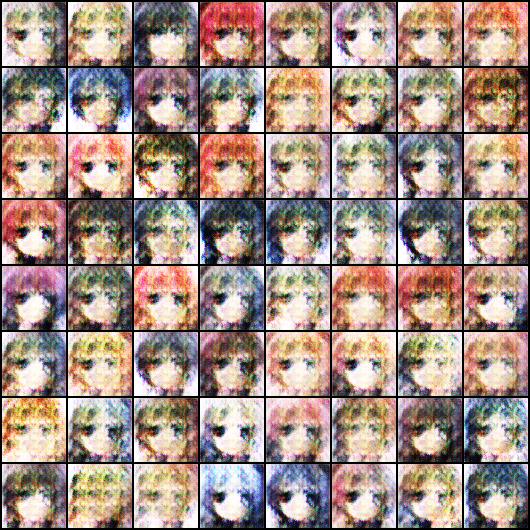

In [ ]:
Image('./generated/generated-images-0001.png')

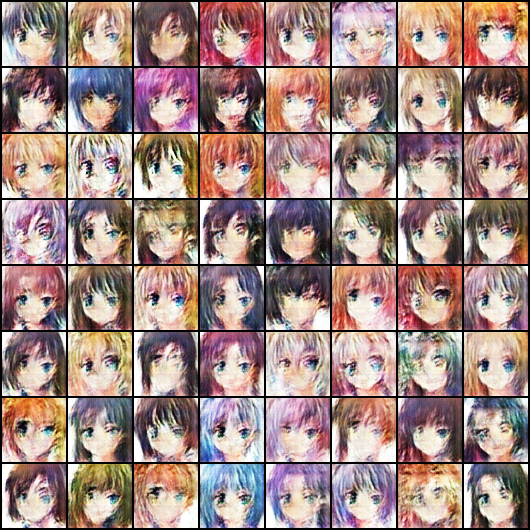

In [ ]:
Image('./generated/generated-images-0005.png')

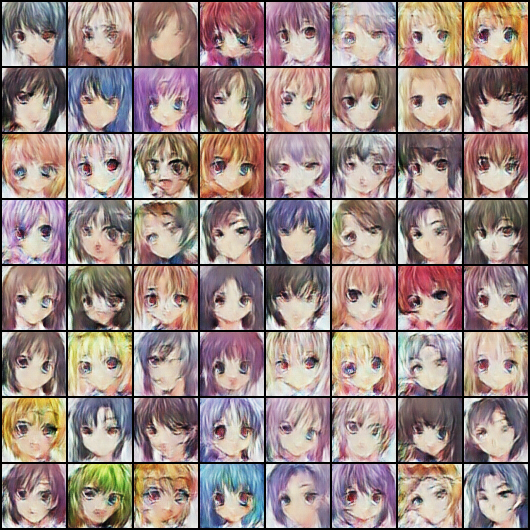

In [ ]:
Image('./generated/generated-images-0010.png')

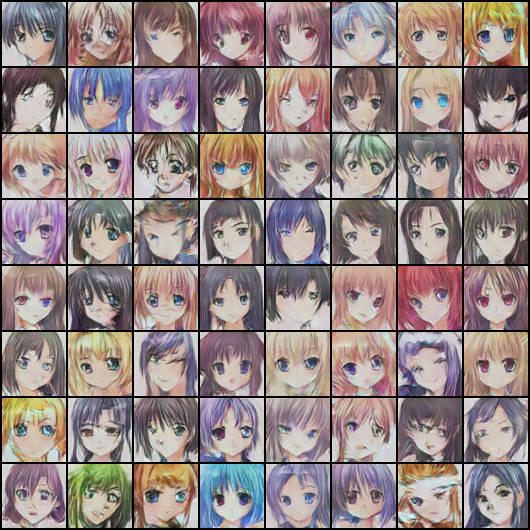

In [ ]:
Image('./generated/generated-images-0020.png')

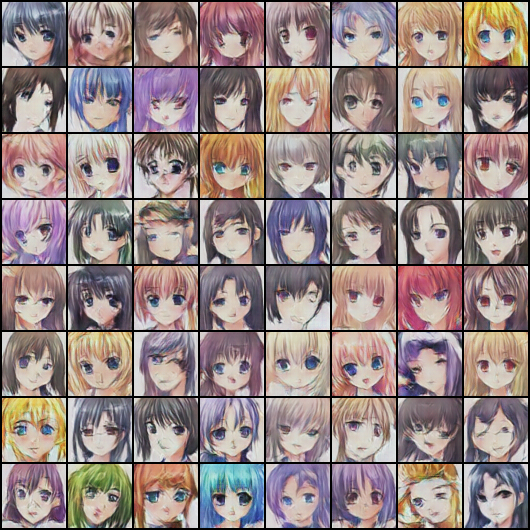

In [ ]:
Image('./generated/generated-images-0025.png')

Podemos visualizar o processo de treinamento combinando as imagens de amostra geradas após cada época em um vídeo usando OpenCV.

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Também podemos visualizar como a função de custo muda ao longo do tempo. Visualizar os valores da função de custo é útil para depurar o processo de treinamento. Para GANs, esperamos que a função de custo do gerador diminua ao longo do tempo, sem que a função de custo do discriminador fique muito alta.


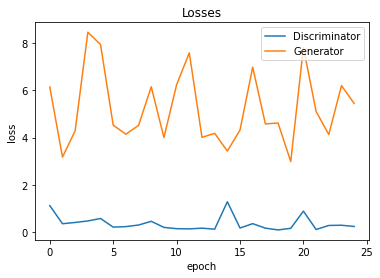

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

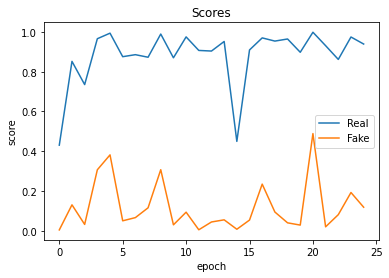

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');